Tutorials for course ECE1508 Reinforcement Learning at the University of Toronto.

Author: Xiaocan (Bruce) Li

Email: hsiaotsan.li@mail.utoronto.ca

#Recap of last tutorial
In the previous tutorial, we covered how to prevent drastic update of policy with TRPO algorithm. However, TRPO requires many mathematical and coding details to get it right.

#Overview

In this tutorial, we are going to achieve similar concept of smooth update of policy by limiting the difference between new and old policies being too large, via the PPO algorithm.


**Related links:**
* PPO algorithm in OpenAI: https://spinningup.openai.com/en/latest/algorithms/ppo.html
* PPO algorithm paper: https://arxiv.org/pdf/1707.06347
* Credit to PPO code: https://github.com/Khrylx/PyTorch-RL/blob/master/core/ppo.py
* Mountain Car Continuous Official Website: https://www.gymlibrary.dev/environments/classic_control/mountain_car/
* OpenAI Leaderboard for Most Games: https://github.com/openai/gym/wiki/Leaderboard#mountaincar-v0

# Import libraries

In [1]:
import torch
import torch.nn as nn
from torch.distributions import Normal
import torch.autograd as autograd
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

import os
import pickle
import gym
import numpy as np
import math
import multiprocessing
import time
import matplotlib.pyplot as plt


import warnings

# Ignore DeprecationWarning within the gym library
warnings.filterwarnings("ignore", category=DeprecationWarning, module="gym.*")

In [2]:
# Load files from google drive
# Only run this code if you run this notebook on *Google Colab* to save your training results.
# You can skip this code block if you run elsewhere.
if True:
  import os
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/Projects/ECE1508_RL/Tutorial5_PPO')
  !ls

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive
 learned_models  'Tutorial 5 - Proximal Policy Optimization, PPO.ipynb'


# Utilities

In [55]:
# Math related utilities
def normal_log_density(x, mean, log_std, std):
    var = std.pow(2)
    log_density = -(x - mean).pow(2) / (2 * var) - 0.5 * math.log(2 * math.pi) - log_std
    return log_density.sum(1, keepdim=True)


# Path related utilities
def check_path(path):
    if not os.path.exists(path):
        print(f"{path} not exist")
        os.makedirs(path)
        print(f"Create {path} success")


# PyTorch related utilities
tensor = torch.tensor
DoubleTensor = torch.DoubleTensor
FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor
ByteTensor = torch.ByteTensor
ones = torch.ones
zeros = torch.zeros


def to_device(device, *args):
    return [x.to(device) for x in args]




# ZFilter related utilities
# from https://github.com/joschu/modular_rl
# http://www.johndcook.com/blog/standard_deviation/
class RunningStat(object):
    def __init__(self, shape):
        self._n = 0
        self._M = np.zeros(shape)
        self._S = np.zeros(shape)

    def push(self, x):
        x = np.asarray(x)

        assert x.shape == self._M.shape, "shape mismatch, expected %s, got %s" % (self._M.shape, x.shape)

        self._n += 1
        if self._n == 1:
            self._M[...] = x
        else:
            oldM = self._M.copy()
            self._M[...] = oldM + (x - oldM) / self._n
            self._S[...] = self._S + (x - oldM) * (x - self._M)

    @property
    def n(self):
        return self._n

    @property
    def mean(self):
        return self._M

    @property
    def var(self):
        return self._S / (self._n - 1) if self._n > 1 else np.square(self._M)

    @property
    def std(self):
        return np.sqrt(self.var)

    @property
    def shape(self):
        return self._M.shape


class ZFilter:
    """
    y = (x-mean)/std
    using running estimates of mean,std
    """

    def __init__(self, shape, demean=True, destd=True, clip=10.0):
        self.demean = demean
        self.destd = destd
        self.clip = clip

        self.rs = RunningStat(shape)
        self.fix = False

    def __call__(self, x, update=True):
        if update and not self.fix:
            self.rs.push(x)
        if self.demean:
            x = x - self.rs.mean
        if self.destd:
            x = x / (self.rs.std + 1e-8)
        if self.clip:
            x = np.clip(x, -self.clip, self.clip)
        return x


# Policy Networks

In [4]:
# For continuous action space
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=(128, 128), activation='tanh', log_std=0):
        super().__init__()
        self.is_disc_action = False
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = torch.relu
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid

        self.affine_layers = nn.ModuleList()
        last_dim = state_dim
        for nh in hidden_size:
            self.affine_layers.append(nn.Linear(last_dim, nh))
            last_dim = nh

        self.action_mean = nn.Linear(last_dim, action_dim)
        self.action_mean.weight.data.mul_(0.1)
        self.action_mean.bias.data.mul_(0.0)

        self.action_log_std = nn.Parameter(torch.ones(1, action_dim) * log_std)

    def forward(self, x):
        for affine in self.affine_layers:
            x = self.activation(affine(x))

        action_mean = self.action_mean(x)
        action_log_std = self.action_log_std.expand_as(action_mean)
        action_std = torch.exp(action_log_std)

        return action_mean, action_log_std, action_std

    def select_action(self, x):
        action_mean, _, action_std = self.forward(x)
        action = torch.normal(action_mean, action_std)
        return action

    # Compute KL Divergence for two gaussian distributions
    def get_kl(self, x):
        mean1, log_std1, std1 = self.forward(x)

        mean0 = mean1.detach()
        log_std0 = log_std1.detach()
        std0 = std1.detach()
        kl = log_std1 - log_std0 + (std0.pow(2) + (mean0 - mean1).pow(2)) / (2.0 * std1.pow(2)) - 0.5
        return kl.sum(1, keepdim=True)

    def get_log_prob(self, x, actions):
        action_mean, action_log_std, action_std = self.forward(x)
        return normal_log_density(actions, action_mean, action_log_std, action_std)


    # Get Fisher Information Matrix
    def get_fim(self, x):
        mean, _, _ = self.forward(x)
        cov_inv = self.action_log_std.exp().pow(-2).squeeze(0).repeat(x.size(0))
        param_count = 0
        std_index = 0
        id = 0
        for name, param in self.named_parameters():
            if name == "action_log_std":
                std_id = id
                std_index = param_count
            param_count += param.view(-1).shape[0]
            id += 1
        return cov_inv.detach(), mean, {'std_id': std_id, 'std_index': std_index}


# For discrete action space
class DiscretePolicy(nn.Module):
    def __init__(self, state_dim, action_num, hidden_size=(128, 128), activation='tanh'):
        super().__init__()
        self.is_disc_action = True
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = torch.relu
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid

        self.affine_layers = nn.ModuleList()
        last_dim = state_dim
        for nh in hidden_size:
            self.affine_layers.append(nn.Linear(last_dim, nh))
            last_dim = nh

        self.action_head = nn.Linear(last_dim, action_num)
        self.action_head.weight.data.mul_(0.1)
        self.action_head.bias.data.mul_(0.0)

    def forward(self, x):
        for affine in self.affine_layers:
            x = self.activation(affine(x))

        action_prob = torch.softmax(self.action_head(x), dim=1)
        return action_prob

    def select_action(self, x):
        action_prob = self.forward(x)
        action = action_prob.multinomial(1)
        return action

    def get_kl(self, x):
        action_prob1 = self.forward(x)
        action_prob0 = action_prob1.detach()
        kl = action_prob0 * (torch.log(action_prob0) - torch.log(action_prob1))
        return kl.sum(1, keepdim=True)

    def get_log_prob(self, x, actions):
        action_prob = self.forward(x)
        return torch.log(action_prob.gather(1, actions.long().unsqueeze(1)))

    def get_fim(self, x):
        action_prob = self.forward(x)
        M = action_prob.pow(-1).view(-1).detach()
        return M, action_prob, {}



# Value Network

In [5]:
class Value(nn.Module):
    def __init__(self, state_dim, hidden_size=(128, 128), activation='tanh'):
        super().__init__()
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = torch.relu
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid

        self.affine_layers = nn.ModuleList()
        last_dim = state_dim
        for nh in hidden_size:
            self.affine_layers.append(nn.Linear(last_dim, nh))
            last_dim = nh

        self.value_head = nn.Linear(last_dim, 1)
        self.value_head.weight.data.mul_(0.1)
        self.value_head.bias.data.mul_(0.0)

    def forward(self, x):
        for affine in self.affine_layers:
            x = self.activation(affine(x))

        value = self.value_head(x)
        return value

# Memory class

In [6]:
from collections import namedtuple
import random

Transition = namedtuple('Transition', ('state', 'action', 'mask', 'next_state',
                                       'reward'))


class Memory(object):
    def __init__(self):
        self.memory = []

    def push(self, *args):
        """Saves a transition."""
        self.memory.append(Transition(*args))

    def sample(self, batch_size=None):
        if batch_size is None:
            return Transition(*zip(*self.memory))
        else:
            random_batch = random.sample(self.memory, batch_size)
            return Transition(*zip(*random_batch))

    def append(self, new_memory):
        self.memory += new_memory.memory

    def __len__(self):
        return len(self.memory)


# Sample Collector

In [60]:
def collect_samples(pid, queue, env, policy, custom_reward,
                    mean_action, render, running_state, min_batch_size):
    if pid > 0:
        torch.manual_seed(torch.randint(0, 5000, (1,)) * pid)
        if hasattr(env, 'np_random'):
            env.np_random.seed(env.np_random.randint(5000) * pid)
        if hasattr(env, 'env') and hasattr(env.env, 'np_random'):
            env.env.np_random.seed(env.env.np_random.randint(5000) * pid)
    log = dict()
    memory = Memory()
    num_steps = 0
    total_reward = 0
    min_reward = 1e6
    max_reward = -1e6
    total_c_reward = 0
    min_c_reward = 1e6
    max_c_reward = -1e6
    num_episodes = 0

    while num_steps < min_batch_size:
        state = env.reset()
        if running_state is not None:
            state = running_state(state)
        reward_episode = 0

        for t in range(10000):
            state_var = tensor(state).unsqueeze(0)
            with torch.no_grad():
                # If in evaluation mode, turn off exploration by using mean action.
                if mean_action:
                    if policy_net.is_disc_action:
                        # Discrete action takes the action with max probability
                        action_prob = policy_net(state_var).cpu().numpy()
                        action = np.argmax(action_prob)
                    else:
                        # Discrete action takes the mean of action distribution
                        action_mean, _, _ = policy_net(state_var)
                        action = action_mean.cpu().numpy()
                else:
                    action = policy.select_action(state_var)[0].numpy()

            action = int(action) if policy.is_disc_action else action.astype(np.float64)
            next_state, reward, done, _ = env.step(action)
            reward_episode += reward
            if running_state is not None:
                next_state = running_state(next_state.squeeze())

            if custom_reward is not None:
                reward = custom_reward(state, action)
                total_c_reward += reward
                min_c_reward = min(min_c_reward, reward)
                max_c_reward = max(max_c_reward, reward)

            mask = 0 if done else 1

            memory.push(state, action, mask, next_state, reward)

            if render:
                env.render()
            if done:
                break

            state = next_state

        # log stats
        num_steps += (t + 1)
        num_episodes += 1
        total_reward += reward_episode
        min_reward = min(min_reward, reward_episode)
        max_reward = max(max_reward, reward_episode)

    log['num_steps'] = num_steps
    log['num_episodes'] = num_episodes
    log['total_reward'] = total_reward
    log['avg_reward'] = total_reward / num_episodes
    log['max_reward'] = max_reward
    log['min_reward'] = min_reward
    if custom_reward is not None:
        log['total_c_reward'] = total_c_reward
        log['avg_c_reward'] = total_c_reward / num_steps
        log['max_c_reward'] = max_c_reward
        log['min_c_reward'] = min_c_reward

    if queue is not None:
        queue.put([pid, memory, log])
    else:
        return memory, log


def merge_log(log_list):
    log = dict()
    log['total_reward'] = sum([x['total_reward'] for x in log_list])
    log['num_episodes'] = sum([x['num_episodes'] for x in log_list])
    log['num_steps'] = sum([x['num_steps'] for x in log_list])
    log['avg_reward'] = log['total_reward'] / log['num_episodes']
    log['max_reward'] = max([x['max_reward'] for x in log_list])
    log['min_reward'] = min([x['min_reward'] for x in log_list])
    if 'total_c_reward' in log_list[0]:
        log['total_c_reward'] = sum([x['total_c_reward'] for x in log_list])
        log['avg_c_reward'] = log['total_c_reward'] / log['num_steps']
        log['max_c_reward'] = max([x['max_c_reward'] for x in log_list])
        log['min_c_reward'] = min([x['min_c_reward'] for x in log_list])

    return log

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Estimate Advantages

In [8]:
def estimate_advantages(rewards, masks, values, gamma, tau, device):
    rewards, masks, values = to_device(torch.device('cpu'), rewards, masks, values)
    tensor_type = type(rewards)
    deltas = tensor_type(rewards.size(0), 1)
    advantages = tensor_type(rewards.size(0), 1)

    prev_value = 0
    prev_advantage = 0
    for i in reversed(range(rewards.size(0))):
        deltas[i] = rewards[i] + gamma * prev_value * masks[i] - values[i]
        advantages[i] = deltas[i] + gamma * tau * prev_advantage * masks[i]

        prev_value = values[i, 0]
        prev_advantage = advantages[i, 0]

    returns = values + advantages
    advantages = (advantages - advantages.mean()) / advantages.std()

    advantages, returns = to_device(device, advantages, returns)
    return advantages, returns

# PPO step

In [9]:
def ppo_step(policy_net, value_net, optimizer_policy, optimizer_value, optim_value_iternum, states, actions,
             returns, advantages, fixed_log_probs, clip_epsilon, l2_reg):

    """update critic"""
    for _ in range(optim_value_iternum):
        values_pred = value_net(states)
        value_loss = (values_pred - returns).pow(2).mean()
        # weight decay
        for param in value_net.parameters():
            value_loss += param.pow(2).sum() * l2_reg
        optimizer_value.zero_grad()
        value_loss.backward()
        optimizer_value.step()

    """update policy"""
    log_probs = policy_net.get_log_prob(states, actions)
    ratio = torch.exp(log_probs - fixed_log_probs)
    surr1 = ratio * advantages
    surr2 = torch.clamp(ratio, 1.0 - clip_epsilon, 1.0 + clip_epsilon) * advantages
    policy_surr = -torch.min(surr1, surr2).mean()
    optimizer_policy.zero_grad()
    policy_surr.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 40)
    optimizer_policy.step()


# Agent

In [10]:
class Agent:

    def __init__(self, env, policy, device, custom_reward=None, running_state=None, num_threads=1):
        self.env = env
        self.policy = policy
        self.device = device
        self.custom_reward = custom_reward
        self.running_state = running_state
        self.num_threads = num_threads

    def collect_samples(self, min_batch_size, mean_action=False, render=False):
        t_start = time.time()
        to_device(torch.device('cpu'), self.policy)
        thread_batch_size = int(math.floor(min_batch_size / self.num_threads))
        queue = multiprocessing.Queue()
        workers = []

        for i in range(self.num_threads-1):
            worker_args = (i+1, queue, self.env, self.policy, self.custom_reward, mean_action,
                           False, self.running_state, thread_batch_size)
            workers.append(multiprocessing.Process(target=collect_samples, args=worker_args))
        for worker in workers:
            worker.start()

        memory, log = collect_samples(0, None, self.env, self.policy, self.custom_reward, mean_action,
                                      render, self.running_state, thread_batch_size)

        worker_logs = [None] * len(workers)
        worker_memories = [None] * len(workers)
        for _ in workers:
            pid, worker_memory, worker_log = queue.get()
            worker_memories[pid - 1] = worker_memory
            worker_logs[pid - 1] = worker_log
        for worker_memory in worker_memories:
            memory.append(worker_memory)
        batch = memory.sample()
        if self.num_threads > 1:
            log_list = [log] + worker_logs
            log = merge_log(log_list)
        to_device(self.device, self.policy)
        t_end = time.time()
        log['sample_time'] = t_end - t_start
        log['action_mean'] = np.mean(np.vstack(batch.action), axis=0)
        log['action_min'] = np.min(np.vstack(batch.action), axis=0)
        log['action_max'] = np.max(np.vstack(batch.action), axis=0)
        return batch, log


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-7-b6fb2253d08f>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action = int(action) if policy.is_disc_action else action.astype(np.float64)
<ipython-input-7-b6fb2253d08f>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befo

0	T_sample 14.6788	T_update 2.4495	T_eval 1.1213	train_R_min -200.00	train_R_max -200.00	train_R_avg -200.00	eval_R_avg -200.00
New best average reward=-200.0. Model saved!
1	T_sample 14.0934	T_update 3.2210	T_eval 1.7744	train_R_min -200.00	train_R_max -200.00	train_R_avg -200.00	eval_R_avg -200.00
2	T_sample 13.9913	T_update 2.5426	T_eval 0.9832	train_R_min -200.00	train_R_max -200.00	train_R_avg -200.00	eval_R_avg -200.00
3	T_sample 13.7589	T_update 2.3890	T_eval 1.0043	train_R_min -200.00	train_R_max -200.00	train_R_avg -200.00	eval_R_avg -200.00
4	T_sample 13.7473	T_update 2.4680	T_eval 1.0468	train_R_min -200.00	train_R_max -200.00	train_R_avg -200.00	eval_R_avg -200.00
5	T_sample 13.7486	T_update 2.7909	T_eval 1.6541	train_R_min -200.00	train_R_max -200.00	train_R_avg -200.00	eval_R_avg -200.00
6	T_sample 14.6161	T_update 4.4348	T_eval 1.3653	train_R_min -200.00	train_R_max -200.00	train_R_avg -200.00	eval_R_avg -200.00
7	T_sample 13.7228	T_update 2.5164	T_eval 1.0411	train_R_mi

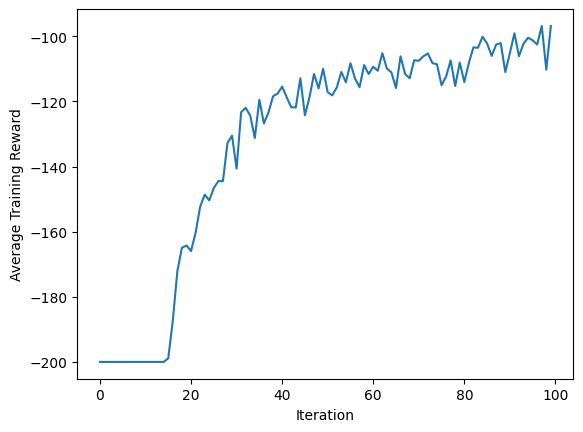

In [ ]:
main_train()

# Train Main - MountainCar-v0

In [69]:
import argparse

parser = argparse.ArgumentParser(description='PyTorch PPO example')
parser.add_argument('--env-name', default="MountainCar-v0", metavar='G',
                    help='name of the environment to run')
parser.add_argument('--model-path', metavar='G',
                    help='path of pre-trained model')
parser.add_argument('--render', action='store_true', default=False,
                    help='render the environment')
parser.add_argument('--log-std', type=float, default=-0.0, metavar='G',
                    help='log std for the policy (default: -0.0)')
parser.add_argument('--gamma', type=float, default=0.99, metavar='G',
                    help='discount factor (default: 0.99)')
parser.add_argument('--tau', type=float, default=0.95, metavar='G',
                    help='gae (default: 0.95)')
parser.add_argument('--l2-reg', type=float, default=1e-3, metavar='G',
                    help='l2 regularization regression (default: 1e-3)')
parser.add_argument('--learning-rate', type=float, default=3e-4, metavar='G',
                    help='learning rate (default: 3e-4)')
parser.add_argument('--clip-epsilon', type=float, default=0.2, metavar='N',
                    help='clipping epsilon for PPO')
parser.add_argument('--num-threads', type=int, default=4, metavar='N',
                    help='number of threads for agent (default: 4)')
parser.add_argument('--seed', type=int, default=1, metavar='N',
                    help='random seed (default: 1)')
parser.add_argument('--min-batch-size', type=int, default=2048, metavar='N',
                    help='minimal batch size per PPO update (default: 2048)')
parser.add_argument('--eval-batch-size', type=int, default=2048, metavar='N',
                    help='minimal batch size for evaluation (default: 2048)')
parser.add_argument('--max-iter-num', type=int, default=500, metavar='N',
                    help='maximal number of main iterations (default: 500)')
parser.add_argument('--log-interval', type=int, default=1, metavar='N',
                    help='interval between training status logs (default: 10)')
parser.add_argument('--save-model-interval', type=int, default=0, metavar='N',
                    help="interval between saving model (default: 0, means don't save)")
parser.add_argument('--gpu-index', type=int, default=0, metavar='N')

args = parser.parse_args(args=[
    '--env-name', 'MountainCar-v0',
    '--render',
    '--log-std', '-0.0',
    '--gamma', '0.99',
    '--tau', '0.95',
    '--l2-reg', '1e-3',
    '--learning-rate', '3e-4',
    '--clip-epsilon', '0.2',
    '--num-threads', '8',
    '--seed', '1',
    '--min-batch-size', '2048',
    '--eval-batch-size', '2048',
    '--max-iter-num', '100',
    '--log-interval', '1',
    '--save-model-interval', '0',
    '--gpu-index', '0'
])

# Printing some of the parsed arguments for demonstration
print("Environment Name:", args.env_name)
print("Model Path:", args.model_path)
print("Render Environment:", args.render, type(args.render))
print("Tau:", args.tau, type(args.tau))
print("GPU Index:", args.gpu_index, type(args.gpu_index))

# optimization epoch number and batch size for PPO
optim_epochs = 10
optim_batch_size = 64



dtype = torch.float64
torch.set_default_dtype(dtype)
device = torch.device('cuda', index=args.gpu_index) if torch.cuda.is_available() else torch.device('cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(args.gpu_index)



"""environment"""
env = gym.make(args.env_name)
state_dim = env.observation_space.shape[0]
is_disc_action = len(env.action_space.shape) == 0
running_state = ZFilter((state_dim,), clip=5)
# running_reward = ZFilter((1,), demean=False, clip=10)

"""seeding"""
np.random.seed(args.seed)
torch.manual_seed(args.seed)
env.seed(args.seed)



"""define actor and critic"""
if args.model_path is None:
    if is_disc_action:
        policy_net = DiscretePolicy(state_dim, env.action_space.n)
    else:
        policy_net = Policy(state_dim, env.action_space.shape[0], log_std=args.log_std)
    value_net = Value(state_dim)
else:
    policy_net, value_net, running_state = pickle.load(open(args.model_path, "rb"))
policy_net.to(device)
value_net.to(device)

optimizer_policy = torch.optim.Adam(policy_net.parameters(), lr=args.learning_rate)
optimizer_value = torch.optim.Adam(value_net.parameters(), lr=args.learning_rate)

"""create agent"""
agent = Agent(env, policy_net, device, running_state=running_state, num_threads=args.num_threads)


def update_params(batch, i_iter):
    states = torch.from_numpy(np.stack(batch.state)).to(dtype).to(device)
    actions = torch.from_numpy(np.stack(batch.action)).to(dtype).to(device)
    rewards = torch.from_numpy(np.stack(batch.reward)).to(dtype).to(device)
    masks = torch.from_numpy(np.stack(batch.mask)).to(dtype).to(device)
    with torch.no_grad():
        values = value_net(states)
        fixed_log_probs = policy_net.get_log_prob(states, actions)

    """get advantage estimation from the trajectories"""
    advantages, returns = estimate_advantages(rewards, masks, values, args.gamma, args.tau, device)

    """perform mini-batch PPO update"""
    optim_iter_num = int(math.ceil(states.shape[0] / optim_batch_size))
    for _ in range(optim_epochs):
        perm = np.arange(states.shape[0])
        np.random.shuffle(perm)
        perm = LongTensor(perm).to(device)

        states, actions, returns, advantages, fixed_log_probs = \
            states[perm].clone(), actions[perm].clone(), returns[perm].clone(), advantages[perm].clone(), fixed_log_probs[perm].clone()

        for i in range(optim_iter_num):
            ind = slice(i * optim_batch_size, min((i + 1) * optim_batch_size, states.shape[0]))
            states_b, actions_b, advantages_b, returns_b, fixed_log_probs_b = \
                states[ind], actions[ind], advantages[ind], returns[ind], fixed_log_probs[ind]

            ppo_step(policy_net, value_net, optimizer_policy, optimizer_value, 1, states_b, actions_b, returns_b,
                     advantages_b, fixed_log_probs_b, args.clip_epsilon, args.l2_reg)


def main_train():
    best_avg_reward = float('-inf')
    average_train_rewards = []

    for i_iter in range(args.max_iter_num):
        """generate multiple trajectories that reach the minimum batch_size"""
        batch, log = agent.collect_samples(args.min_batch_size, render=args.render)
        t0 = time.time()
        update_params(batch, i_iter)
        t1 = time.time()
        """evaluate with determinstic action (remove noise for exploration)"""
        _, log_eval = agent.collect_samples(args.eval_batch_size, mean_action=True)
        t2 = time.time()

        average_train_rewards.append(log['avg_reward'])

        if i_iter % args.log_interval == 0:
            print('{}\tT_sample {:.4f}\tT_update {:.4f}\tT_eval {:.4f}\ttrain_R_min {:.2f}\ttrain_R_max {:.2f}\ttrain_R_avg {:.2f}\teval_R_avg {:.2f}'.format(
                i_iter, log['sample_time'], t1-t0, t2-t1, log['min_reward'], log['max_reward'], log['avg_reward'], log_eval['avg_reward']))

        # Save best model
        if log['avg_reward'] > best_avg_reward:
            best_avg_reward = log['avg_reward']
            to_device(torch.device('cpu'), policy_net, value_net)
            check_path('learned_models')
            pickle.dump((policy_net, value_net, running_state),
                        open(os.path.join('learned_models/{}_PPO.p'.format(args.env_name)), 'wb'))
            print(f'New best average reward={best_avg_reward}. Model saved!')
            to_device(device, policy_net, value_net)

        """clean up gpu memory"""
        torch.cuda.empty_cache()

    plt.plot(average_train_rewards)
    plt.xlabel('Iteration')
    plt.ylabel('Average Training Reward')
    plt.show()



Environment Name: MountainCar-v0
Model Path: None
Render Environment: True <class 'bool'>
Tau: 0.95 <class 'float'>
GPU Index: 0 <class 'int'>


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-60-e9274a67af49>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action = int(action) if policy.is_disc_action else action.astype(np.float64)
<ipython-input-60-e9274a67af49>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action = int(action) if policy.is_disc_action else action.astype(np.float64)
<ipython-input-60-e9274a67af49>:42: DeprecationWarning: Conversion of an array with ndim > 0 to 

0	T_sample 14.5919	T_update 3.1365	T_eval 1.1133	train_R_min -200.00	train_R_max -200.00	train_R_avg -200.00	eval_R_avg -200.00
New best average reward=-200.0. Model saved!
1	T_sample 13.8656	T_update 3.2082	T_eval 1.3523	train_R_min -200.00	train_R_max -200.00	train_R_avg -200.00	eval_R_avg -200.00
2	T_sample 14.0598	T_update 4.0381	T_eval 1.8433	train_R_min -200.00	train_R_max -200.00	train_R_avg -200.00	eval_R_avg -200.00
3	T_sample 14.0183	T_update 3.2628	T_eval 1.1387	train_R_min -200.00	train_R_max -200.00	train_R_avg -200.00	eval_R_avg -200.00
4	T_sample 13.9542	T_update 3.2862	T_eval 1.1586	train_R_min -200.00	train_R_max -200.00	train_R_avg -200.00	eval_R_avg -200.00
5	T_sample 13.7856	T_update 3.2442	T_eval 1.8687	train_R_min -200.00	train_R_max -200.00	train_R_avg -200.00	eval_R_avg -200.00
6	T_sample 14.1215	T_update 4.5579	T_eval 1.1518	train_R_min -200.00	train_R_max -200.00	train_R_avg -200.00	eval_R_avg -200.00
7	T_sample 13.8239	T_update 3.3866	T_eval 1.1603	train_R_mi

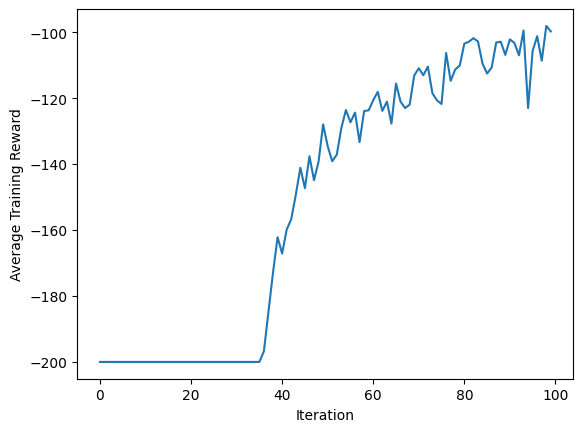

In [70]:
main_train()

# Eval Main - MountainCar-v0

In [71]:
import argparse

parser = argparse.ArgumentParser(description='PyTorch PPO example')
parser.add_argument('--env-name', default="MountainCar-v0", metavar='G',
                    help='name of the environment to run')
parser.add_argument('--model-path', metavar='G', required=True,
                    help='path of pre-trained model')
parser.add_argument('--render', action='store_true', default=False,
                    help='render the environment')
parser.add_argument('--seed', type=int, default=1, metavar='N',
                    help='random seed (default: 1)')
parser.add_argument('--gpu-index', type=int, default=0, metavar='N')
parser.add_argument('--num-eval', type=int, default=1, metavar='N')

args = parser.parse_args(args=[
    '--env-name', 'MountainCar-v0',
    '--model-path', 'learned_models/MountainCar-v0_PPO.p',
    '--seed', '1',
    '--gpu-index', '0',
    '--num-eval', '10'
])


dtype = torch.float64
torch.set_default_dtype(dtype)
device = torch.device('cuda', index=args.gpu_index) if torch.cuda.is_available() else torch.device('cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(args.gpu_index)

"""environment"""
env = gym.make(args.env_name)
state_dim = env.observation_space.shape[0]
is_disc_action = len(env.action_space.shape) == 0
running_state = None  # to be loaded later

"""seeding"""
np.random.seed(args.seed)
torch.manual_seed(args.seed)
env.seed(args.seed)

"""define actor and critic"""
policy_net, value_net, running_state = pickle.load(open(args.model_path, "rb"))
policy_net.to(device)
value_net.to(device)

"""create agent"""
agent = Agent(env, policy_net, device, running_state=running_state, num_threads=1)
mean_action = True  # In evaluation, there is no exploration of action, just use mean action.



def main_eval():
    episode_rewards = []

    for e in range(1, args.num_eval+1):
        done = False
        state = env.reset()
        if running_state is not None:
            state = running_state(state)
        reward_episode = 0

        while not done:
            state_var = tensor(state, dtype=dtype).unsqueeze(0).to(device)
            with torch.no_grad():
              if policy_net.is_disc_action:
                    # Discrete action takes the action with max probability
                    action_prob = policy_net(state_var).cpu().numpy()
                    action = np.argmax(action_prob)
              else:
                    # Discrete action takes the mean of action distribution
                    action_mean, _, _ = policy_net(state_var)
                    action = action_mean.cpu().numpy()
            next_state, reward, done, _ = env.step(action)

            if running_state is not None:
                next_state = running_state(next_state)

            state = next_state


            if args.render:
                env.render()
            reward_episode += reward


        print(f"Episode {e} Total Reward {reward_episode}")
        episode_rewards.append(reward_episode)

    """clean up gpu memory"""
    torch.cuda.empty_cache()

    env.close()
    print(f"Number of Episodes {args.num_eval} Mean Reward {np.mean(episode_rewards)} Std Reward {np.std(episode_rewards)}")

    return episode_rewards

main_eval()


Episode 1 Total Reward -104.0
Episode 2 Total Reward -85.0
Episode 3 Total Reward -109.0
Episode 4 Total Reward -85.0
Episode 5 Total Reward -107.0
Episode 6 Total Reward -106.0
Episode 7 Total Reward -88.0
Episode 8 Total Reward -106.0
Episode 9 Total Reward -104.0
Episode 10 Total Reward -111.0
Number of Episodes 10 Mean Reward -100.5 Std Reward 9.728823155962905


[-104.0, -85.0, -109.0, -85.0, -107.0, -106.0, -88.0, -106.0, -104.0, -111.0]

# Train Main - CartPole-v0

In [74]:
import argparse

parser = argparse.ArgumentParser(description='PyTorch PPO example')
parser.add_argument('--env-name', default="MountainCar-v0", metavar='G',
                    help='name of the environment to run')
parser.add_argument('--model-path', metavar='G',
                    help='path of pre-trained model')
parser.add_argument('--render', action='store_true', default=False,
                    help='render the environment')
parser.add_argument('--log-std', type=float, default=-0.0, metavar='G',
                    help='log std for the policy (default: -0.0)')
parser.add_argument('--gamma', type=float, default=0.99, metavar='G',
                    help='discount factor (default: 0.99)')
parser.add_argument('--tau', type=float, default=0.95, metavar='G',
                    help='gae (default: 0.95)')
parser.add_argument('--l2-reg', type=float, default=1e-3, metavar='G',
                    help='l2 regularization regression (default: 1e-3)')
parser.add_argument('--learning-rate', type=float, default=3e-4, metavar='G',
                    help='learning rate (default: 3e-4)')
parser.add_argument('--clip-epsilon', type=float, default=0.2, metavar='N',
                    help='clipping epsilon for PPO')
parser.add_argument('--num-threads', type=int, default=4, metavar='N',
                    help='number of threads for agent (default: 4)')
parser.add_argument('--seed', type=int, default=1, metavar='N',
                    help='random seed (default: 1)')
parser.add_argument('--min-batch-size', type=int, default=2048, metavar='N',
                    help='minimal batch size per PPO update (default: 2048)')
parser.add_argument('--eval-batch-size', type=int, default=2048, metavar='N',
                    help='minimal batch size for evaluation (default: 2048)')
parser.add_argument('--max-iter-num', type=int, default=500, metavar='N',
                    help='maximal number of main iterations (default: 500)')
parser.add_argument('--log-interval', type=int, default=1, metavar='N',
                    help='interval between training status logs (default: 10)')
parser.add_argument('--save-model-interval', type=int, default=0, metavar='N',
                    help="interval between saving model (default: 0, means don't save)")
parser.add_argument('--gpu-index', type=int, default=0, metavar='N')

args = parser.parse_args(args=[
    '--env-name', 'CartPole-v0',
    '--render',
    '--log-std', '-0.0',
    '--gamma', '0.99',
    '--tau', '0.95',
    '--l2-reg', '1e-3',
    '--learning-rate', '3e-4',
    '--clip-epsilon', '0.2',
    '--num-threads', '8',
    '--seed', '1',
    '--min-batch-size', '2048',
    '--eval-batch-size', '2048',
    '--max-iter-num', '50',
    '--log-interval', '1',
    '--save-model-interval', '0',
    '--gpu-index', '0'
])

# Printing some of the parsed arguments for demonstration
print("Environment Name:", args.env_name)
print("Model Path:", args.model_path)
print("Render Environment:", args.render, type(args.render))
print("Tau:", args.tau, type(args.tau))
print("GPU Index:", args.gpu_index, type(args.gpu_index))

# optimization epoch number and batch size for PPO
optim_epochs = 10
optim_batch_size = 64



dtype = torch.float64
torch.set_default_dtype(dtype)
device = torch.device('cuda', index=args.gpu_index) if torch.cuda.is_available() else torch.device('cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(args.gpu_index)



"""environment"""
env = gym.make(args.env_name)
state_dim = env.observation_space.shape[0]
is_disc_action = len(env.action_space.shape) == 0
running_state = ZFilter((state_dim,), clip=5)
# running_reward = ZFilter((1,), demean=False, clip=10)

"""seeding"""
np.random.seed(args.seed)
torch.manual_seed(args.seed)
env.seed(args.seed)



"""define actor and critic"""
if args.model_path is None:
    if is_disc_action:
        policy_net = DiscretePolicy(state_dim, env.action_space.n)
    else:
        policy_net = Policy(state_dim, env.action_space.shape[0], log_std=args.log_std)
    value_net = Value(state_dim)
else:
    policy_net, value_net, running_state = pickle.load(open(args.model_path, "rb"))
policy_net.to(device)
value_net.to(device)

optimizer_policy = torch.optim.Adam(policy_net.parameters(), lr=args.learning_rate)
optimizer_value = torch.optim.Adam(value_net.parameters(), lr=args.learning_rate)

"""create agent"""
agent = Agent(env, policy_net, device, running_state=running_state, num_threads=args.num_threads)


def update_params(batch, i_iter):
    states = torch.from_numpy(np.stack(batch.state)).to(dtype).to(device)
    actions = torch.from_numpy(np.stack(batch.action)).to(dtype).to(device)
    rewards = torch.from_numpy(np.stack(batch.reward)).to(dtype).to(device)
    masks = torch.from_numpy(np.stack(batch.mask)).to(dtype).to(device)
    with torch.no_grad():
        values = value_net(states)
        fixed_log_probs = policy_net.get_log_prob(states, actions)

    """get advantage estimation from the trajectories"""
    advantages, returns = estimate_advantages(rewards, masks, values, args.gamma, args.tau, device)

    """perform mini-batch PPO update"""
    optim_iter_num = int(math.ceil(states.shape[0] / optim_batch_size))
    for _ in range(optim_epochs):
        perm = np.arange(states.shape[0])
        np.random.shuffle(perm)
        perm = LongTensor(perm).to(device)

        states, actions, returns, advantages, fixed_log_probs = \
            states[perm].clone(), actions[perm].clone(), returns[perm].clone(), advantages[perm].clone(), fixed_log_probs[perm].clone()

        for i in range(optim_iter_num):
            ind = slice(i * optim_batch_size, min((i + 1) * optim_batch_size, states.shape[0]))
            states_b, actions_b, advantages_b, returns_b, fixed_log_probs_b = \
                states[ind], actions[ind], advantages[ind], returns[ind], fixed_log_probs[ind]

            ppo_step(policy_net, value_net, optimizer_policy, optimizer_value, 1, states_b, actions_b, returns_b,
                     advantages_b, fixed_log_probs_b, args.clip_epsilon, args.l2_reg)


def main_train():
    best_avg_reward = float('-inf')
    average_train_rewards = []

    for i_iter in range(args.max_iter_num):
        """generate multiple trajectories that reach the minimum batch_size"""
        batch, log = agent.collect_samples(args.min_batch_size, render=args.render)
        t0 = time.time()
        update_params(batch, i_iter)
        t1 = time.time()
        """evaluate with determinstic action (remove noise for exploration)"""
        _, log_eval = agent.collect_samples(args.eval_batch_size, mean_action=True)
        t2 = time.time()

        average_train_rewards.append(log['avg_reward'])

        if i_iter % args.log_interval == 0:
            print('{}\tT_sample {:.4f}\tT_update {:.4f}\tT_eval {:.4f}\ttrain_R_min {:.2f}\ttrain_R_max {:.2f}\ttrain_R_avg {:.2f}\teval_R_avg {:.2f}'.format(
                i_iter, log['sample_time'], t1-t0, t2-t1, log['min_reward'], log['max_reward'], log['avg_reward'], log_eval['avg_reward']))

        # Save best model
        if log['avg_reward'] > best_avg_reward:
            best_avg_reward = log['avg_reward']
            to_device(torch.device('cpu'), policy_net, value_net)
            check_path('learned_models')
            pickle.dump((policy_net, value_net, running_state),
                        open(os.path.join('learned_models/{}_PPO.p'.format(args.env_name)), 'wb'))
            print(f'New best average reward={best_avg_reward}. Model saved!')
            to_device(device, policy_net, value_net)

        """clean up gpu memory"""
        torch.cuda.empty_cache()

    plt.plot(average_train_rewards)
    plt.xlabel('Iteration')
    plt.ylabel('Average Training Reward')
    plt.show()



Environment Name: CartPole-v0
Model Path: None
Render Environment: True <class 'bool'>
Tau: 0.95 <class 'float'>
GPU Index: 0 <class 'int'>


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


<ipython-input-60-e9274a67af49>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action = int(action) if policy.is_disc_action else action.astype(np.float64)
<ipython-input-60-e9274a67af49>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action = int(action) if policy.is_disc_action else action.astype(np.float64)
<ipython-input-60-e9274a67af49>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action = int(action) if policy.is_disc_action else action.astype(np.f

0	T_sample 6.2347	T_update 2.7301	T_eval 1.3643	train_R_min 10.00	train_R_max 48.00	train_R_avg 20.58	eval_R_avg 37.32
New best average reward=20.58252427184466. Model saved!
1	T_sample 6.2937	T_update 2.1456	T_eval 1.2877	train_R_min 9.00	train_R_max 80.00	train_R_avg 25.64	eval_R_avg 91.15
New best average reward=25.63529411764706. Model saved!
2	T_sample 6.3861	T_update 3.6639	T_eval 1.0758	train_R_min 11.00	train_R_max 157.00	train_R_avg 44.62	eval_R_avg 197.56
New best average reward=44.62264150943396. Model saved!
3	T_sample 6.4719	T_update 7.8185	T_eval 1.8056	train_R_min 17.00	train_R_max 200.00	train_R_avg 109.13	eval_R_avg 200.00
New best average reward=109.1304347826087. Model saved!
4	T_sample 9.0450	T_update 3.0601	T_eval 1.0988	train_R_min 102.00	train_R_max 200.00	train_R_avg 161.19	eval_R_avg 200.00
New best average reward=161.1875. Model saved!
5	T_sample 8.1581	T_update 4.6984	T_eval 1.0726	train_R_min 151.00	train_R_max 200.00	train_R_avg 175.56	eval_R_avg 200.00
New

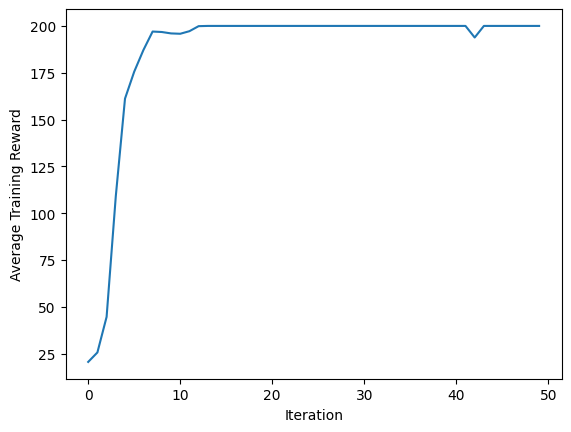

In [75]:
main_train()

# Eval Main - CartPole-v0

In [76]:
import argparse

parser = argparse.ArgumentParser(description='PyTorch PPO example')
parser.add_argument('--env-name', default="CartPole-v0", metavar='G',
                    help='name of the environment to run')
parser.add_argument('--model-path', metavar='G', required=True,
                    help='path of pre-trained model')
parser.add_argument('--render', action='store_true', default=False,
                    help='render the environment')
parser.add_argument('--seed', type=int, default=1, metavar='N',
                    help='random seed (default: 1)')
parser.add_argument('--gpu-index', type=int, default=0, metavar='N')
parser.add_argument('--num-eval', type=int, default=1, metavar='N')

args = parser.parse_args(args=[
    '--env-name', 'CartPole-v0',
    '--model-path', 'learned_models/CartPole-v0_PPO.p',
    '--seed', '1',
    '--gpu-index', '0',
    '--num-eval', '10'
])


dtype = torch.float64
torch.set_default_dtype(dtype)
device = torch.device('cuda', index=args.gpu_index) if torch.cuda.is_available() else torch.device('cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(args.gpu_index)

"""environment"""
env = gym.make(args.env_name)
state_dim = env.observation_space.shape[0]
is_disc_action = len(env.action_space.shape) == 0
running_state = None  # to be loaded later

"""seeding"""
np.random.seed(args.seed)
torch.manual_seed(args.seed)
env.seed(args.seed)

"""define actor and critic"""
policy_net, value_net, running_state = pickle.load(open(args.model_path, "rb"))
policy_net.to(device)
value_net.to(device)

"""create agent"""
agent = Agent(env, policy_net, device, running_state=running_state, num_threads=1)
mean_action = True  # In evaluation, there is no exploration of action, just use mean action.



def main_eval():
    episode_rewards = []

    for e in range(1, args.num_eval+1):
        done = False
        state = env.reset()
        if running_state is not None:
            state = running_state(state)
        reward_episode = 0

        while not done:
            state_var = tensor(state, dtype=dtype).unsqueeze(0).to(device)
            with torch.no_grad():
              if policy_net.is_disc_action:
                    # Discrete action takes the action with max probability
                    action_prob = policy_net(state_var).cpu().numpy()
                    action = np.argmax(action_prob)
              else:
                    # Discrete action takes the mean of action distribution
                    action_mean, _, _ = policy_net(state_var)
                    action = action_mean.cpu().numpy()
            next_state, reward, done, _ = env.step(action)

            if running_state is not None:
                next_state = running_state(next_state)

            state = next_state


            if args.render:
                env.render()
            reward_episode += reward


        print(f"Episode {e} Total Reward {reward_episode}")
        episode_rewards.append(reward_episode)

    """clean up gpu memory"""
    torch.cuda.empty_cache()

    env.close()
    print(f"Number of Episodes {args.num_eval} Mean Reward {np.mean(episode_rewards)} Std Reward {np.std(episode_rewards)}")

    return episode_rewards

main_eval()


Episode 1 Total Reward 200.0
Episode 2 Total Reward 200.0
Episode 3 Total Reward 200.0
Episode 4 Total Reward 200.0
Episode 5 Total Reward 200.0
Episode 6 Total Reward 200.0
Episode 7 Total Reward 200.0
Episode 8 Total Reward 200.0
Episode 9 Total Reward 200.0
Episode 10 Total Reward 200.0
Number of Episodes 10 Mean Reward 200.0 Std Reward 0.0


[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]

# Conclusion


In this tutorial, we have covered the PPO algorithm. The two most important features of PPO algorithms are:

**Clipped Objective Function**: PPO simplifies policy updates by using a clipped surrogate objective, which helps prevent excessive policy updates and encourages gradual, stable improvements without the computational complexity of trust regions.

**Efficient and Scalable**: Designed for efficiency, PPO achieves similar or better performance than TRPO with simpler implementation and faster computation, making it highly scalable for both continuous and discrete action spaces.